This notebook intends to serve as the basis for LIneA doc PD 003 - 20018

In [1]:
%matplotlib notebook
import pandas, numpy
import matplotlib.pyplot as plt

Call the angbao code (this assumes you are in root dir of repo)

In [2]:
from sys import path
path.append("..")
import angbao

# Input data

CSV files to be easily loaded as a MultiIndex Pandas.DataFrame

1. Measurements

In [3]:
cldf = pandas.read_csv("../test/data/apsmeasurements_nside1024_dl15lmin0lmax450.csv.gz", header=[0,1], index_col=0)
print("Shape:", cldf.shape)
cldf.head(1)

Shape: (30, 7204)


zbin      zp0607                                                             \
data       mock0     mock1    mock2     mock3     mock4     mock5     mock6   
elleff                                                                        
8.0     0.000014  0.000106  0.00006  0.000033  0.000116  0.000047  0.000034   

zbin                                  ...      zp0910                      \
data       mock7     mock8    mock9   ...    mock1791  mock1792  mock1793   
elleff                                ...                                   
8.0     0.000024  0.000048  0.00004   ...     0.00001  0.000029  0.000026   

zbin                                                                       
data    mock1794 mock1795 mock1796  mock1797  mock1798  mock1799       y1  
elleff                                                                     
8.0     0.000024  0.00003  0.00001  0.000018  0.000018  0.000011  0.00006  

[1 rows x 7204 columns]

2. Covariance (optional)

In [4]:
covdf = pandas.read_csv("../test/data/apscov_analytical_rsdnl_dl15lmin0lmax450.csv.gz", header=None, index_col=None)
print("Shape:", covdf.shape)

Shape: (120, 120)


3. Templates

In [5]:
tpdf = pandas.read_csv("../test/data/apstemplates_mc_rsd.csv.gz", header=[0,1], index_col=0)
print("Shape:", tpdf.shape)
tpdf.head(1)

Shape: (1025, 8)


type        wg                                      nw                      \
zbin    zp0607    zp0708    zp0809    zp0910    zp0607    zp0708    zp0809   
ell                                                                          
0.0   0.000072  0.000041  0.000031  0.000027  0.000073  0.000042  0.000031   

type            
zbin    zp0910  
ell             
0.0   0.000028

# Configuration parameters

In [6]:
measfn = "../test/data/apsmeasurements_nside1024_dl15lmin0lmax450.csv.gz"
tempfn = "../test/data/apstemplates_mc_rsd.csv.gz"
A, B = 0, 0
data = 'y1'
template = 'wg'

In [7]:
# Derived
kind = "aA%dB%d" % (A, B)

# Running test

## Loading data

In [8]:
ll, dd, icc, model = angbao.loadreddat(measfn, tempfn)

Loading datasets: ../test/data/apsmeasurements_nside1024_dl15lmin0lmax450.csv.gz, ../test/data/apstemplates_mc_rsd.csv.gz
Selecting datavector: y1
Selecting full cov from mocks
Computing prec. matrix
Debiasing Prec.Mat. from mocks (nb, ns)=(120, 1800). 1-D=9.327404e-01
Interpolating templates


## Profiling likelihood PDF

In [9]:
da, amin, amax = 0.001, 0.8, 1.2
alpha = numpy.linspace(amin, amax, int((amax - amin) / da) + 1)
out = angbao.profiled_likelihood(alpha, ll, dd, icc, model,
                                 template=template, kind=kind)

Minimum found at: 204.35340656134997 / 111 [1.0215538847117793, 2.6585197776197546e-06, 0.9158579730161064, 3.0781178315864295e-06, 0.9279444560934895, 2.72900986138685e-06, 0.8768689890114787, 3.349891459923985e-06, 0.7865108242935068]


## Structured output data

In [10]:
dof = (len(ll) * len(ll[0]) - (out.shape[1] - 1))
out_red = numpy.concatenate((out,
                       out[:, -1].reshape(out.shape[0], 1) / dof),
                       axis=1)
names = ['alpha']\
        + ['nuis%d' % (i) for i in range(out_red.shape[1] - 3)]\
        + ['chi2', 'chi2_red']
outdf = pandas.DataFrame(data=out_red, columns=names).set_index('alpha')

<IPython.core.display.Javascript object>


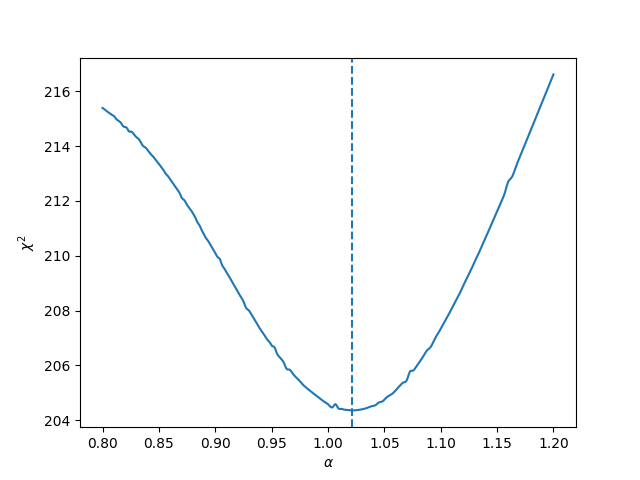

Text(0, 0.5, '$\\chi^2$')

In [11]:
f, ax = plt.subplots(ncols=1, nrows=1)
outdf['chi2'].plot(ax=ax)
ax.axvline(x=outdf['chi2'].idxmin(), linestyle='--')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\chi^2$')